## Maximum Covering Location Problem (MCLP) solved by SA

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import time

In [2]:
class SimulatedAnnealing:
    # Constructor:
    #   - Data_Dict: file object from 'open_file' method
    #   - Iter: int for the number of iterations annealing runs for
    #   - Alpha: Parameter for decreasing temperature
    #   - Beta: Parameter for increasing the # of inner-loop iterations
    def __init__(self, p, n, r, dist, iter, alpha=None, beta=None):
        # Get dataset variables
        self.p = p
        self.r = r
        self.num_vertices = n
        self.vertices = list(range(0, n))
        self.dist = dist
        self.best_iter = 0.9
        self.best_solution = None
        self.best_score = None

        # Generate initial solution randomly
        self.S = np.zeros(self.num_vertices)
        selected_vertices = random.sample(self.vertices, self.p)
        for i in range(self.num_vertices):
            if i + 1 in selected_vertices:
                self.S[i] = 1

        # Initialize SA variables
        self.T = 10
        self.iterations = iter
        self.alpha = alpha if alpha else 0.9
        self.beta = beta if beta else 1.02

    # Method to begin annealing process
    def start(self):
        count = 0
        timer = 0

        while self.T > 1:
            i = 0
            while i < self.iterations:
                # Perturb S to get new solution
                new_S = self.perturb(self.S)

                # Calculate scores for both solutions
                h_S = self.score(self.S)
                h_new_S = self.score(new_S)

                # Simulated annealing condition statement
                random_num = random.uniform(0, 1)
                if (h_new_S < h_S) or (random_num < np.exp((h_S - h_new_S) / self.T)):
                    self.S = copy.deepcopy(new_S)

                    # Set aside best score
                    if self.best_solution is None:
                        self.best_solution = copy.deepcopy(self.S)
                        self.best_score = h_S
                        self.best_iter = count + 1
                    if h_new_S < self.best_score:
                        self.best_solution = copy.deepcopy(new_S)
                        self.best_score = h_new_S
                        self.best_iter = count + 1

                # Print scores and increment counters
                i += 1
                count += 1

            # Update temp and iterations with parameters
            self.T = self.alpha * self.T
            self.iterations = self.beta * self.iterations

            # Update timer
            timer += 1
        print("第%s代最优值：%s" % (timer, self.best_score))

    # Method to perturb solution
    def perturb(self, S):
        # Randomly choose index and flip bit
        solution = copy.deepcopy(S)
        index = random.randint(0, self.num_vertices - 1)
        if solution[index] == 0:
            solution[index] = 1
        elif solution[index] == 1:
            solution[index] = 0

        # Fix up solution if infeasible
        while np.sum(solution) < self.p:
            solution[random.choice(np.where(solution == 0)[0])] = 1
        while np.sum(solution) > self.p:
            solution[random.choice(np.where(solution == 1)[0])] = 0

        # Return new solution
        return solution

    # Method to score solutions
    def score(self, solution):
        # Get list of centers and remaining points to be assigned
        centers = np.where(solution == 1)[0]
        rem_points = np.where(solution == 0)[0]

        no_cover = self.num_vertices - self.p
        for i in rem_points:
            for j in centers:
                if self.dist[i, j] > self.r:
                    continue
                else:
                    no_cover -= 1
                    break
        return no_cover


## Load the real-world datasets

In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
road_net = gpd.read_file("./data/beijing/chaoyang_pro.shp")
road_net.head(3)

,name,type,oneway,bridge,tunnel,city,province,X,geometry
0,慧忠路,城市次干道,是,否,否,北京市,北京市,0.0,"LINESTRING (961352.924 4442947.246, 961371.635..."
1,None,城市支路,否,否,否,北京市,北京市,0.0,"LINESTRING (961576.716 4442949.777, 961581.935..."
2,北四环中路,城市快速路,是,否,否,北京市,北京市,0.0,"LINESTRING (958939.391 4441974.277, 958962.436..."


In [5]:
poi = gpd.read_file("./data/poi/emergency_cy.shp")
poi['POINT_X'] = poi['X']
poi['POINT_Y'] = poi['Y']
# poi['speed_pct_freeflow_rev']=1
print("The number of records is ", len(poi))

The number of records is  132


(955230.2199318785, 983314.839218135, 4421011.349599884, 4458191.154659854)

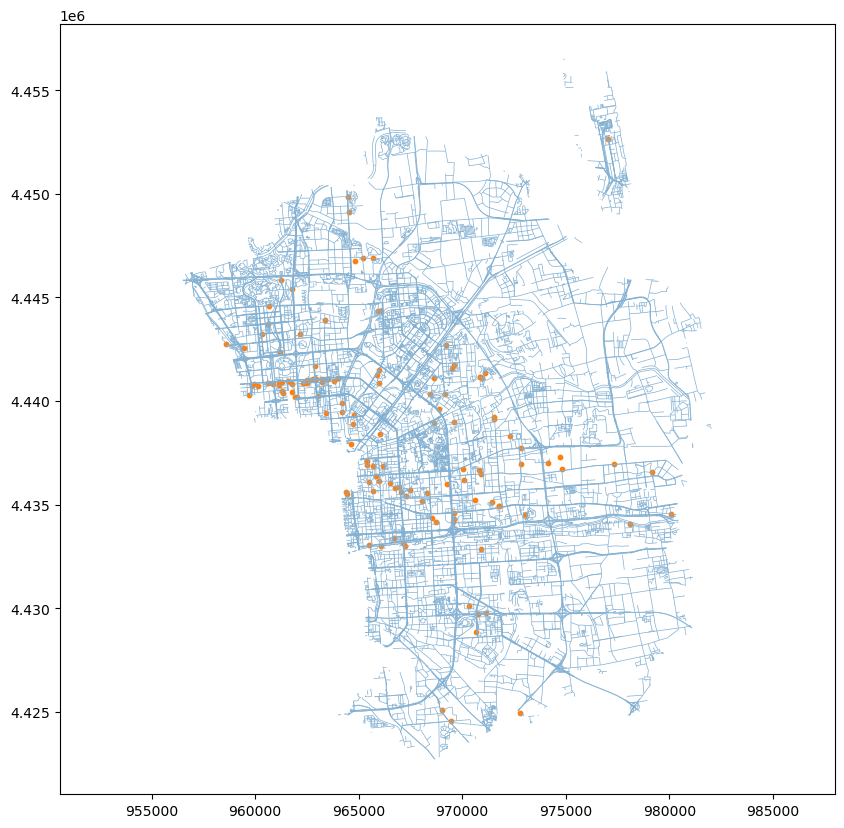

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
road_net.plot(ax=ax, color='#82b0d2', edgecolor='gray', linewidth=0.5)
ax.scatter(poi['X'], poi['Y'], c='C1', s=10, label = 'Emergency Location')
ax.axis('equal')

In [7]:
loc = np.array(poi[['POINT_X', 'POINT_Y']])
p = 20
real_radius = 2000
dist = np.sum((loc[:, np.newaxis, :] - loc[np.newaxis, :, :]) ** 2, axis=-1) ** 0.5
np_dist = np.array(dist)

In [8]:
SA = SimulatedAnnealing(p=p, n=len(poi), r=real_radius, dist=np_dist, iter=5)
SA.start()
obj = len(poi) - SA.best_score
best_solution = [i for i, x in enumerate(SA.best_solution) if x == 1]
print(f"The objective of emergency location is: {obj}")

第22代最优值：22
The objective of emergency location is: 110


In [9]:
def plot_result(ls, opt_sites, radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Pandas DataFrame
        radius: the radius of circle
    '''
    fig, ax = plt.subplots(figsize=(12, 12))
    road_net.plot(ax=ax, color='#82b0d2', edgecolor='gray', linewidth=0.5)
    # ls.plot(ax=ax, column=ls['speed_pct_freeflow_rev'], k=5, markersize=5, cmap='Blues', label='Demand Points')
    legend_plot_flag = {'current': False, 'selected': False}
    ax.scatter(ls['POINT_X'], ls['POINT_Y'], c='#fa7f6f', s=20, label = 'Billboards')

    for cnt, site in opt_sites.iterrows():
        if 'current' in opt_sites.columns and site['current'] == True:  #ncurrent
            if legend_plot_flag['current'] == False:
                ax.scatter(site['POINT_X'], site['POINT_Y'], c='red', marker='+', s=10, label='Current Billboards')
                circlelabel = 'Service Range for Current Billboards'
                legend_plot_flag['current'] = True
            ax.scatter(site['POINT_X'], site['POINT_Y'], c='red', marker='+', s=100)
            #             circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='red', fill=False, lw=2, label = circlelabel)
            circle = plt.Circle(site[['POINT_X', 'POINT_Y']], radius, color='red', fill=False, lw=2)

            ax.add_artist(circle)
        else:
            if legend_plot_flag['selected'] == False:
                ax.scatter(site['POINT_X'], site['POINT_Y'], c='b', marker='+', s=10,
                           label='Optimized Selected Billboards')
                circlelabel = 'Service Range for Optimized Selected Billboards'
                legend_plot_flag['selected'] = True
            ax.scatter(site['POINT_X'], site['POINT_Y'], c='b', marker='+', s=100)
            #             circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='C1', fill=False, lw=2, label = circlelabel)
            circle = plt.Circle(site[['POINT_X', 'POINT_Y']], radius, color='#8983bf', fill=False, lw=2)
            ax.add_artist(circle)
    #
    ax.axis('equal')
    return ax

<AxesSubplot:>

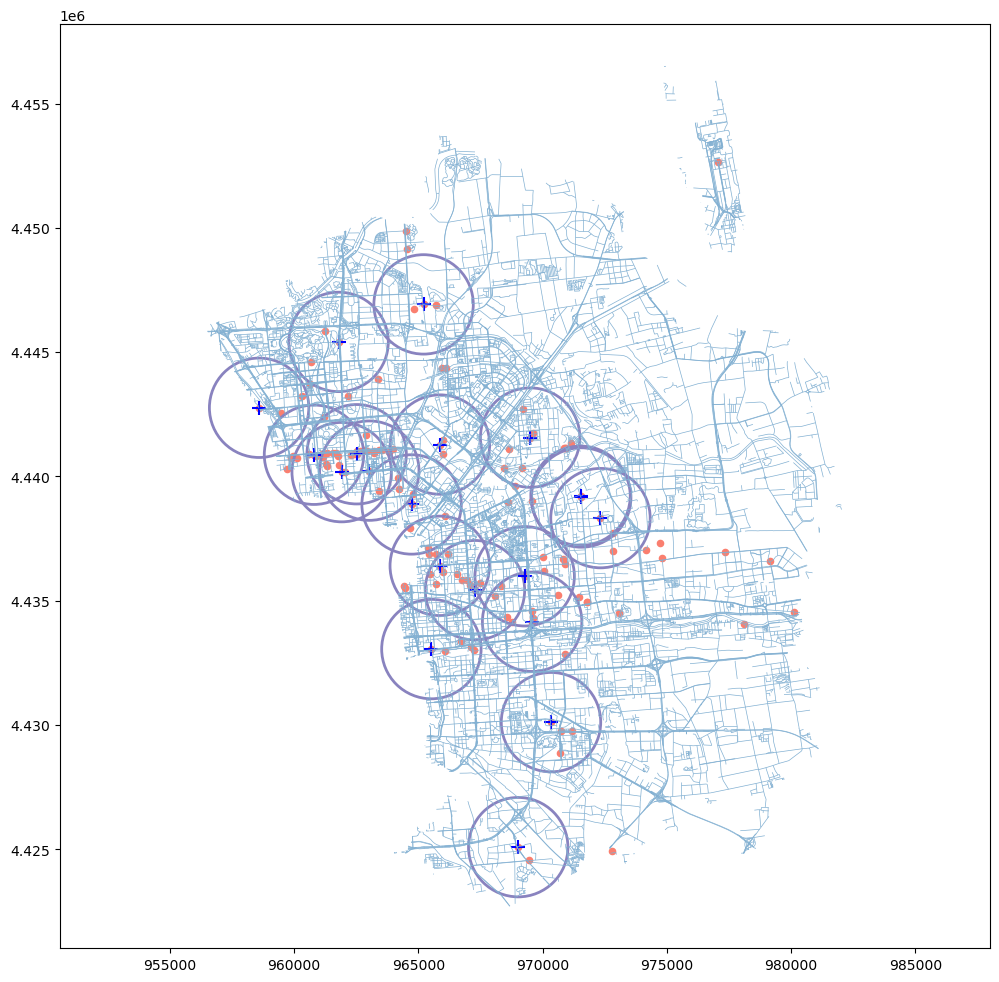

In [10]:
opt_sites = poi.iloc[best_solution]
plot_result(poi,opt_sites,2000)